# Задание 1

Реализовать методы Gauss-Newton и Powell Dog Leg для решения нелинейной регрессии. Сравнить эффективность с методами реализованными в предыдущих работах.

In [1]:
import numpy as np

def grad(f, x, params, delta=1e-6):
    n_features = len(params)
    param_d = np.copy(params)
    ans = np.zeros(n_features, dtype=float)

    for i in range(n_features):
        param_d[i] += delta
        f_plus = f(x, param_d)
        param_d[i] -= delta
        param_d[i] -= delta
        f_minus = f(x, param_d)
        param_d[i] += delta
        ans[i] = np.divide(f_plus - f_minus, delta)

    return ans

def numerical_jacobian(x, params, func):
    """
    Numerical approximation of the Jacobian matrix using finite differences.

    Arguments:
    params -- array-like, shape (n_features,), parameter values
    x -- array-like, shape (n_samples, n_features), input data
    func -- function, the function for which the Jacobian is calculated
    epsilon -- float, step size for finite differences (default: 1e-6)

    Returns:
    jacobian -- array-like, shape (n_samples, n_features), Jacobian matrix
    """

    n_samples, n_features = x.shape[0], len(params)
    jacobian = np.zeros((n_samples, n_features), dtype=float)

    for i in range(n_samples):
        jacobian[i] = grad(func, x[i], params)

    return jacobian


In [2]:
import matplotlib.pyplot as plt

def print_generated(X, Y, Dataset_X, Dataset_Y, RES = None):
    # Plot style:
    plt.style.use('default')
    _ = plt.figure(figsize=(8, 8))
    # ===========
    plt.axis('equal') 
    plt.scatter(Dataset_X, Dataset_Y, label='Data', color='gray', alpha=0.5, s=20.8, antialiased=True)
    plt.plot(X, Y, label='Real', color='lime', antialiased=True, linewidth=1.7)
    if RES is not None:
        plt.plot(X, RES, label='Real', color='r', antialiased=True, linewidth=1)
    plt.legend()
    plt.show()

In [3]:
def mse_loss(dataset_X, dataset_Y, w, f):
    y_pred = f(dataset_X, w)
    mse = np.mean((dataset_Y - y_pred) ** 2)
    return mse

## Gauss-Newton

### Реализация

In [4]:
import numpy as np

def gauss_newton(x, y, f, initial_params, max_iter=100):
    """
    Gauss-Newton method for nonlinear regression.

    Arguments:
    x -- array-like, shape (n_samples, n_features), input data
    y -- array-like, shape (n_samples,), target values
    f -- function, the nonlinear model function f(params, x)
    initial_params -- array-like, shape (n_features,), initial parameter values
    max_iter -- int, maximum number of iterations (default: 100)

    Returns:
    params -- array-like, shape (n_features,), estimated parameters
    """

    params = np.array(initial_params)

    for iteration in range(max_iter):
        # Evaluate the model function and its Jacobian at the current parameters
        model = f(x, params)
        jacobian = numerical_jacobian(x, params, f)

        # Calculate the update direction using the Gauss-Newton approximation
        residuals = y - model
        jacobian_T = jacobian.T
        update = np.linalg.inv(jacobian_T @ jacobian) @ jacobian_T @ residuals
        # Update the parameters
        params += update.reshape(params.shape)

    return params


In [5]:
def gauss_newton_fast(x, y, f, initial_params, max_iter=100, epsilon=2e-2, delta=1e-6):
    params = np.array(initial_params)

    for iteration in range(max_iter):
        # ==========================================================================

        n_samples, n_features = x.shape[0], len(params)
        jacobian = np.zeros((n_samples, n_features), dtype=float)

        for i in range(n_samples):
            jacobian[i] = np.zeros(n_features, dtype=float)

            for j in range(n_features):
                params[j] += delta
                f_plus = f(x[i], params)
                params[j] -= delta
                params[j] -= delta
                f_minus = f(x[i], params)
                params[j] += delta
                jacobian[i][j] = np.divide(f_plus - f_minus, delta)
        # ==========================================================================    
    
        residuals = y - f(x, params)
        jacobian_T = jacobian.T

        # ==========================================================================    

        update = (np.linalg.inv(jacobian_T @ jacobian) @ jacobian_T) @ residuals
        params += update

        if np.linalg.norm(update) < epsilon:
            return params, iteration

    return params, max_iter


### Пример

result_weights [2.00161856 3.0049403 ]
count_step 7
loss 0.010766171282713965


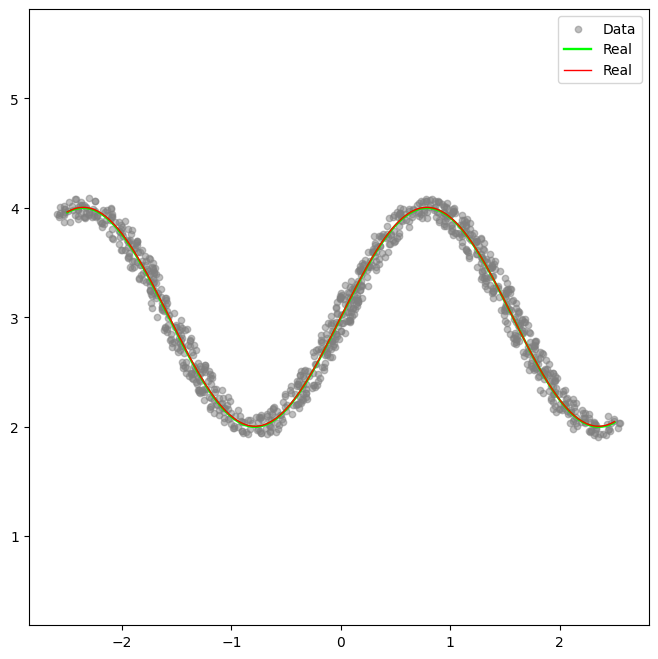

In [6]:
from dataset_generator import Generator

def example():
    def f(x, w):
        return_value = np.sin(w[0] * x)  + w[1]
        return return_value

    density = 8000
    dots_count = 1000
    variance = 0.1
    dist = 2.5
    weights = np.array([2, 3], dtype=float)
    init_weights = np.array([3, 4], dtype=float)

    gen = Generator(f)
    X, Y, Dataset_X, Dataset_Y = gen.generate(dots_count, dist, density, variance, weights)
    
    result_weights, count_step = gauss_newton_fast(Dataset_X, Dataset_Y, f, init_weights, epsilon=2e-2, max_iter=100)
    print("result_weights", result_weights)
    print('count_step', count_step)
    print("loss", mse_loss(Dataset_X, Dataset_Y, result_weights, f))
    print_generated(X, Y, Dataset_X, Dataset_Y, f(X, result_weights))

example()

### Исследования

In [7]:
from tqdm import tqdm
import concurrent.futures

def research():
    def f(x, w):
        return_value = np.sin(w[0] * x + w[1])
        return return_value

    density = 8000
    dots_count = 1000
    variance = 0.1
    dist = 2.5
    weights = np.array([2, 3], dtype=float)


    gen = Generator(f)
    X, Y, Dataset_X, Dataset_Y = gen.generate(dots_count, dist, density, variance, weights)

    init_dist = 10
    init_density = 100
    init_x = np.linspace(weights[0]-init_dist, weights[0]+init_dist, init_density)
    init_y = np.linspace(weights[1]-init_dist, weights[1]+init_dist, init_density)
    init_X, init_Y = np.meshgrid(init_x, init_y)

    # ======================================================================================

    progress_bar = tqdm(total=len(init_x) * len(init_y))

    # Определение функции, принимающей значения float для x и y
    def my_function(x, y, i, j):
        result_weights = np.array([x, y], dtype=float)
        result_weights, count_step = gauss_newton_fast(Dataset_X, Dataset_Y, f, result_weights, max_iter=100)
        result_loss = mse_loss(Dataset_X, Dataset_Y, result_weights, f)
        progress_bar.update(1)
        return result_loss, i, j

    # init_Z = np.zeros((len(init_x), len(init_y)), dtype=float)

    # with tqdm(total=len(init_x) * len(init_y)) as pbar:
    #     for i in range(len(init_x)):
    #         for j in range(len(init_y)):
    #             init_Z[i][j] = my_function(init_x[i], init_y[j])
    #             pbar.update(1)

    init_Z = np.zeros((len(init_x), len(init_y)), dtype=float)

    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        # Submit the tasks to the executor
        futures = [executor.submit(my_function, init_x[i], init_y[j], i, j) for i in range(len(init_x)) for j in range(len(init_y))]

        # Retrieve the results as they become available
        for future in concurrent.futures.as_completed(futures):
            result, i, j = future.result()
            init_Z[i][j] = result
        
        progress_bar.close()
    # ======================================================================================

    # Создаем трехмерную фигуру и оси
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(init_X, init_Y, init_Z, cmap='inferno')

    # Настройка меток и заголовка
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('График функции mse')

    # Отображение графика
    plt.show()

research()

  1%|          | 67/10000 [00:29<1:05:33,  2.53it/s]

## Powell Dog Leg

### Реализация

### Исследования